In [1]:
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
from efficientnet_pytorch import EfficientNet

In [3]:
from torchvision import transforms

In [4]:
from sklearn.metrics import roc_auc_score
from collections import Counter

# Load the data

In [5]:
path = Path('data')
path.ls()

(#5) [Path('data/.ipynb_checkpoints'),Path('data/test.csv'),Path('data/sample_submission.csv'),Path('data/images'),Path('data/train.csv')]

In [6]:
Path.BASE_PATH = path
path.ls()

(#5) [Path('.ipynb_checkpoints'),Path('test.csv'),Path('sample_submission.csv'),Path('images'),Path('train.csv')]

In [7]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


### Class Distribution

In [8]:
# dictionary to store labels of individual rows to be latter used 
# for oversampling
idx_labels = {} 

In [9]:
counter = Counter()
for idx, row in df.iterrows():
    label = row.loc[row==1].index[0]
    counter[label] += 1
    idx_labels[idx] = label

In [10]:
counter

Counter({'scab': 592, 'multiple_diseases': 91, 'healthy': 516, 'rust': 622})

**Plot distribution of images in the dataset**

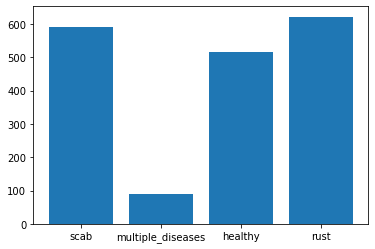

In [11]:
plt.bar([0, 1, 2, 3], counter.values())
plt.xticks([0, 1, 2, 3], counter.keys());

*The dataset is imbalanced so we will oversample from the classes with a low number of samples*

In [12]:
max(counter.values())

622

In [13]:
def oversample(df: pd.DataFrame, cond, limit: int):
    grouped = df.groupby(cond)
    lst = []
    
    for name, group in grouped:
        if len(group) < limit:
            lst.append(group.sample(limit, replace=True))
        else:
            lst.append(group)
    return pd.concat(lst)

In [14]:
df_oversampled = oversample(df, idx_labels, max(counter.values()))

In [15]:
counter = Counter()
for idx, row in df_oversampled.iterrows():
    label = row.loc[row==1].index[0]
    counter[label] += 1

In [16]:
counter

Counter({'healthy': 622, 'multiple_diseases': 622, 'rust': 622, 'scab': 622})

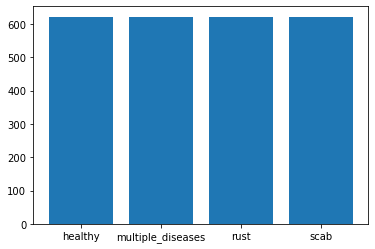

In [17]:
plt.bar([0, 1, 2, 3], counter.values())
plt.xticks([0, 1, 2, 3], counter.keys());

## Create DataLoaders

In [18]:
dblock = DataBlock()

In [19]:
dsets = dblock.datasets(df_oversampled)
dsets.train[0]

(image_id             Train_1509
 healthy                       0
 multiple_diseases             0
 rust                          1
 scab                          0
 Name: 1509, dtype: object,
 image_id             Train_1509
 healthy                       0
 multiple_diseases             0
 rust                          1
 scab                          0
 Name: 1509, dtype: object)

**Define get_x and get_y functions to return the dependent and independent variables in their right formats**
- get_x returns the path to the image
- get_y returns the label(s) as a list because the problem is a multi-category classification problem

In [20]:
def get_x(r): return path/'images'/f'{r["image_id"]}.jpg'
def get_y(r): return r.loc[r==1].index[0]

In [21]:
dblock = DataBlock(get_x=get_x, 
                   get_y=get_y)
dsets = dblock.datasets(df_oversampled)
dsets.train[0]

(Path('images/Train_903.jpg'), 'healthy')

**Define complete DataBlock**

In [22]:
@Transform
def efficientnet_norm(x: TensorImage):
    return  x * 2.0 - 1.0

In [23]:
def get_dls(size, bs):
    db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   splitter=RandomSplitter(seed=420),
                   item_tfms=Resize(size*2),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75, flip_vert=True),
                               Normalize.from_stats(*imagenet_stats)])
    return db.dataloaders(df_oversampled, bs=bs)

In [24]:
dls = get_dls(512, 32)

*Appearance of images is due to normalization scheme used, which is the one used for the efficientnet model that will be used to train the model*

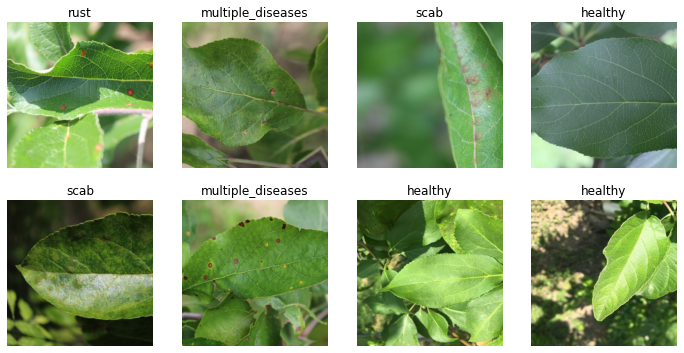

In [25]:
dls.show_batch()

# Define Learner

In [25]:
opt_func = partial(Adam, wd=0.01, eps=1e-8)

In [26]:
model = EfficientNet.from_pretrained("efficientnet-b3", advprop=True)

Loaded pretrained weights for efficientnet-b3


In [27]:
dls.c

4

*Replace the head of the pretrained model*

In [28]:
model._fc

Linear(in_features=1536, out_features=1000, bias=True)

In [29]:
model._fc = nn.Linear(1536, dls.c)

In [30]:
model._fc

Linear(in_features=1536, out_features=4, bias=True)

**Define roc metric**

In [31]:
def roc(preds, targs):
    preds, targs = preds.cpu(), targs.cpu()
    labels = range(dls.c)
    targs = np.eye(dls.c)[targs]
    return np.mean([roc_auc_score(targs[:, i], preds[:, i]) for i in labels])

**Learner**

In [32]:
mixup = MixUp()

In [33]:
learn = Learner(dls, model, opt_func=opt_func,
                loss_func=LabelSmoothingCrossEntropy(),
                metrics=[accuracy, 
                         AccumMetric(roc, flatten=False)],
                cbs=mixup).to_fp16()

SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.0012022644514217973)

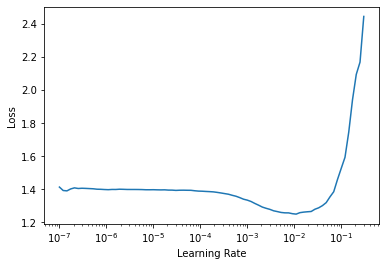

In [46]:
learn.lr_find()

In [34]:
learn.fit_one_cycle(50, 1e-3)

epoch,train_loss,valid_loss,accuracy,roc,time
0,1.288181,1.131831,0.704225,0.921581,01:36
1,1.015827,0.703392,0.814889,0.977804,01:32
2,0.853270,0.503794,0.947686,0.995165,01:30
3,0.771564,0.455103,0.977867,0.997516,01:31
4,0.749124,0.479870,0.947686,0.993507,01:30
5,0.736375,0.445274,0.969819,0.997764,01:30
6,0.737725,0.466572,0.955734,0.994841,01:30
7,0.738526,0.605933,0.899396,0.982354,01:30
8,0.750098,0.622574,0.927565,0.971258,01:31
9,0.756557,0.577119,0.907445,0.985961,01:31


In [35]:
learn.save('eb3-512-mixup')

In [47]:
learn.load('eb3-512')

## Model Intepretation

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

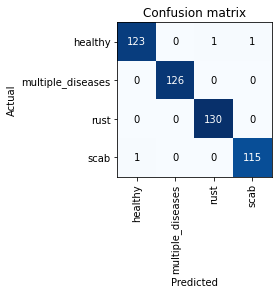

In [37]:
interp.plot_confusion_matrix()

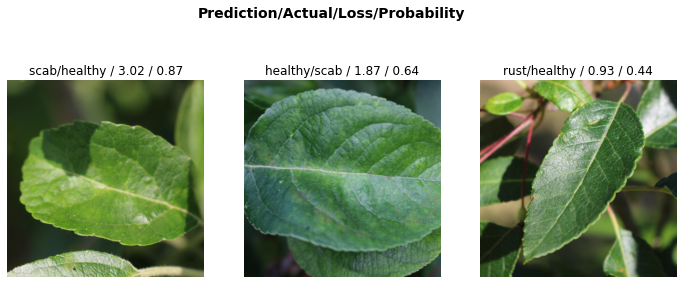

In [39]:
interp.plot_top_losses(3, figsize=(12, 5))

## Increase image sizes

In [34]:
dls = get_dls(768, 2)

Shape of images before progessive resizing

In [35]:
xb, yb = learn.dls.train.one_batch()
xb.shape, yb.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8]))

Apply progressize resizing

In [36]:
learn.dls = dls

In [37]:
xb, yb = learn.dls.train.one_batch()
xb.shape, yb.shape

(torch.Size([2, 3, 768, 768]), torch.Size([2]))

## Train for a few epochs on new images

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=7.585775847473997e-07)

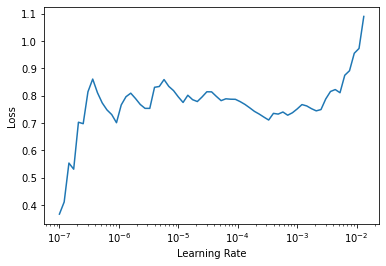

In [38]:
learn.lr_find()

In [39]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,roc,time
0,0.566292,0.402348,0.983903,0.999059,16:25
1,0.475663,0.436647,0.981891,0.995528,16:19
2,0.443456,0.472145,0.973843,0.992421,16:18
3,0.466751,0.443345,0.977867,0.994510,16:16
4,0.409118,0.465860,0.973843,0.992533,16:18


## Evaluate on test set

In [40]:
test_df = pd.read_csv(path/'test.csv')
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [41]:
test_dl = learn.dls.test_dl(test_df, with_labels=False)

In [42]:
probs, classes = learn.get_preds(dl=test_dl)

In [55]:
probs_tta, classes_tta = learn.tta(dl=test_dl)

In [43]:
probs.shape

torch.Size([1821, 4])

In [44]:
probs[0]

tensor([0.0568, 0.0382, 0.8591, 0.0459])

In [45]:
probs_df = pd.DataFrame(probs)

In [56]:
probs_tta_df = pd.DataFrame(probs_tta)
probs_tta_df.head()

,0,1,2,3
0,-0.525291,-0.790741,2.139404,-0.930267
1,-1.217590,-0.656723,2.630249,-0.800629
2,-0.667938,-0.916748,-0.812805,2.713867
3,2.593262,-0.906738,-0.641174,-1.048523
4,-1.158691,-0.700195,2.652466,-0.853424


In [47]:
probs_df.head()

,0,1,2,3
0,0.056802,0.038210,0.859100,0.045888
1,0.019599,0.031720,0.918869,0.029812
2,0.034153,0.024148,0.027123,0.914576
3,0.915195,0.025949,0.034868,0.023988
4,0.021524,0.029536,0.920619,0.028321


In [48]:
learn.dls.vocab

(#4) ['healthy','multiple_diseases','rust','scab']

In [57]:
# probs_df.columns = learn.dls.vocab
probs_tta_df.columns = learn.dls.vocab

In [58]:
# probs_df.head()
probs_tta_df.head()

,healthy,multiple_diseases,rust,scab
0,-0.525291,-0.790741,2.139404,-0.930267
1,-1.217590,-0.656723,2.630249,-0.800629
2,-0.667938,-0.916748,-0.812805,2.713867
3,2.593262,-0.906738,-0.641174,-1.048523
4,-1.158691,-0.700195,2.652466,-0.853424


In [59]:
# combined = pd.concat([test_df, probs_df], axis=1)
combined = pd.concat([test_df, probs_tta_df], axis=1)

In [60]:
combined

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,-0.525291,-0.790741,2.139404,-0.930267
1,Test_1,-1.217590,-0.656723,2.630249,-0.800629
2,Test_2,-0.667938,-0.916748,-0.812805,2.713867
3,Test_3,2.593262,-0.906738,-0.641174,-1.048523
4,Test_4,-1.158691,-0.700195,2.652466,-0.853424
...,...,...,...,...,...
1816,Test_1816,-1.060852,-0.945190,2.747192,-0.820984
1817,Test_1817,-0.831268,-0.375229,-0.906189,2.114929
1818,Test_1818,-0.754211,-0.813385,2.295288,-0.704468
1819,Test_1819,2.665527,-0.829681,-0.998749,-0.835358


export predictions to a csv file

In [54]:
combined.to_csv('eb3-512_mixup.csv', index=False)